In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

In [10]:
df = pd.read_csv('London Gas Oil Futures Historical Data.csv')

In [11]:
df = np.array(df['Price']).reshape(-1,1)

In [12]:
train_index = round(len(df)*0.1)
train = df[:-train_index]
test = df[-train_index:]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train.reshape(-1,1))
test = scaler.transform(test.reshape(-1,1))

In [15]:
test.shape

(131, 1)

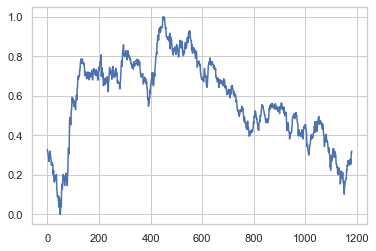

In [16]:
plt.plot(train)

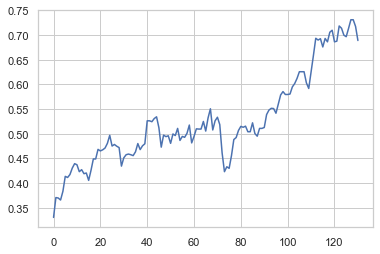

In [17]:
plt.plot(test)

In [18]:
batch_len = 5
batch_count = 1 

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
train_generated = TimeseriesGenerator(train, train, length=batch_len, 
                                      batch_size=batch_count)
test_generated = TimeseriesGenerator(test, test, length=batch_len, 
                                     batch_size=batch_count)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
lstm = Sequential()
lstm.add(LSTM(100, activation='relu', 
              input_shape=((batch_len,batch_count))))
lstm.add(Dense(1))

In [21]:
lstm.compile(optimizer='adam', loss='mse')

In [22]:
lstm.fit(train_generated, validation_data=test_generated, epochs=15,
        callbacks=[EarlyStopping(patience=3)])

Epoch 1/15
1176/1176 [==============================] - 4s 4ms/step - loss: 0.0079 - val_loss: 0.0012
Epoch 2/15
1176/1176 [==============================] - 5s 4ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 3/15
1176/1176 [==============================] - 4s 4ms/step - loss: 9.7493e-04 - val_loss: 7.1246e-04
Epoch 4/15
1176/1176 [==============================] - 5s 4ms/step - loss: 8.6890e-04 - val_loss: 4.8759e-04
Epoch 5/15
1176/1176 [==============================] - 5s 4ms/step - loss: 8.1263e-04 - val_loss: 4.9513e-04
Epoch 6/15
1176/1176 [==============================] - 4s 4ms/step - loss: 6.7742e-04 - val_loss: 4.1102e-04
Epoch 7/15
1176/1176 [==============================] - 5s 5ms/step - loss: 6.1346e-04 - val_loss: 5.4533e-04
Epoch 8/15
1176/1176 [==============================] - 6s 5ms/step - loss: 5.3698e-04 - val_loss: 4.8133e-04
Epoch 9/15
1176/1176 [==============================] - 5s 4ms/step - loss: 4.8843e-04 - val_loss: 4.6157e-04


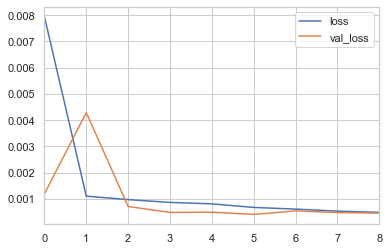

In [23]:
lstm_losses = pd.DataFrame(lstm.history.history)
lstm_losses.plot()

In [24]:
test_predictions = []

batch = train[-5:].reshape(1,batch_len,batch_count)

for i in range(len(test)):
    
    prediction = lstm.predict(batch)[0]
    
    test_predictions.append(prediction)
    
    batch = np.append(batch[:,1:,:], [[prediction]], axis=1)

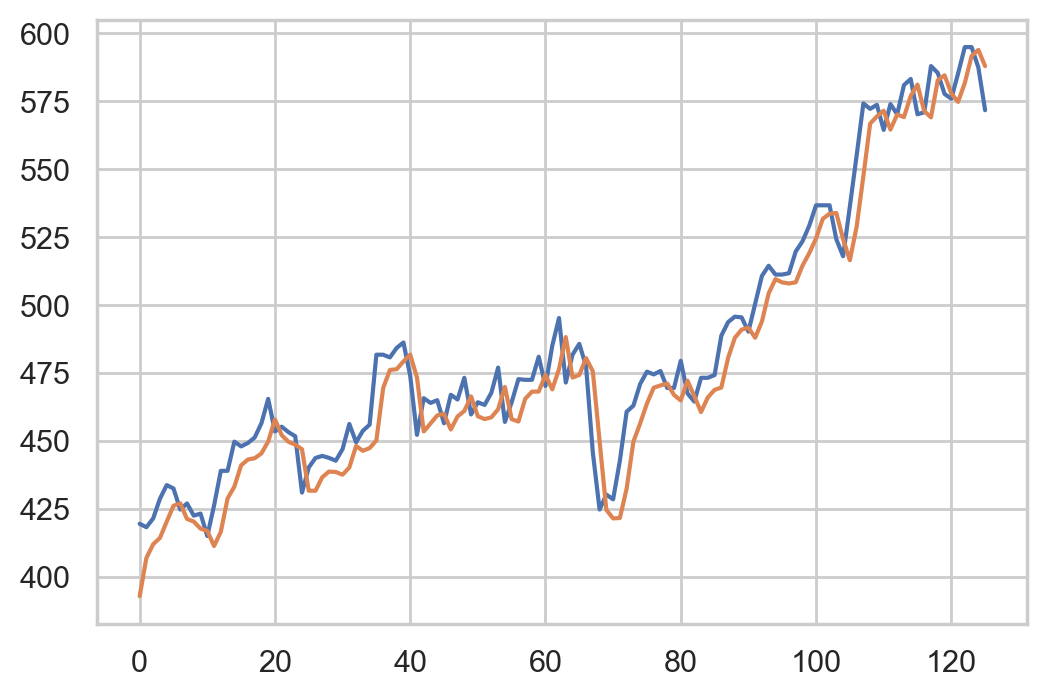

In [62]:
#test starts from 5
plt.figure(dpi=200)
plt.plot(scaler.inverse_transform(test[5:]))
plt.plot(scaler.inverse_transform(lstm.predict(test_generated)))

In [34]:
from sklearn.metrics import mean_squared_error

In [36]:
mean_squared_error(scaler.inverse_transform(test[5:]),
                  scaler.inverse_transform(lstm.predict(test_generated)))**0.5

11.880701872847753

In [39]:
forecast = pd.DataFrame()

In [55]:
forecast['Actual_Price'] = scaler.inverse_transform(test[5:]).reshape(126,)

In [59]:
forecast['Prediction'] = scaler.inverse_transform(lstm.predict(test_generated)).reshape(126,)

In [63]:
b=forecast['Actual_Price'][:-1]
a=forecast['Prediction'][1:]

In [64]:
mean_squared_error(a,b)**0.5

5.640198309820928

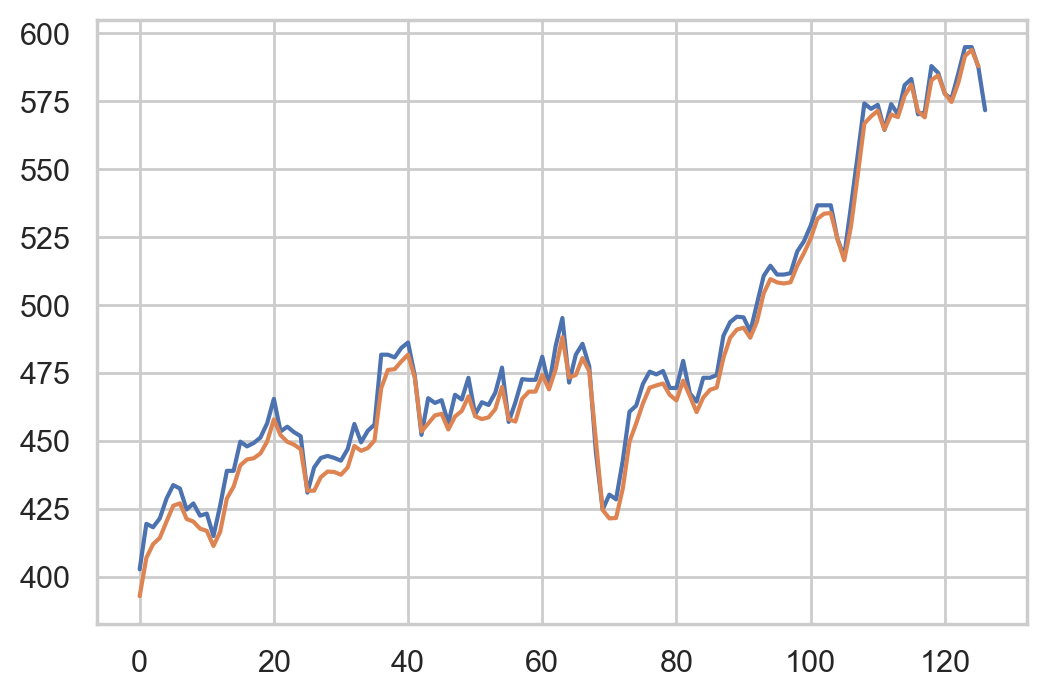

In [65]:
#test starts from 4

plt.figure(dpi=200)
plt.plot(scaler.inverse_transform(test[4:]))
plt.plot(scaler.inverse_transform(lstm.predict(test_generated)))